In [1]:
import n2d2
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from neurocorgi_sdk.models import NeuroCorgiNet_torch

In [2]:
# If possible, set up the GPU 0 for the application
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n2d2.global_variables.default_model = "Frame_CUDA" if n2d2.global_variables.cuda_available else "Frame"
n2d2.global_variables.cuda_device = 0

n2d2.global_variables.verbosity = 0

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [4]:
!ls ants_and_bees

train  val


In [5]:
!ls ants_and_bees/train

ants  bees


In [6]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [7]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=True, drop_last=True)

In [8]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [9]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [10]:
classes = ('ant', 'bee')

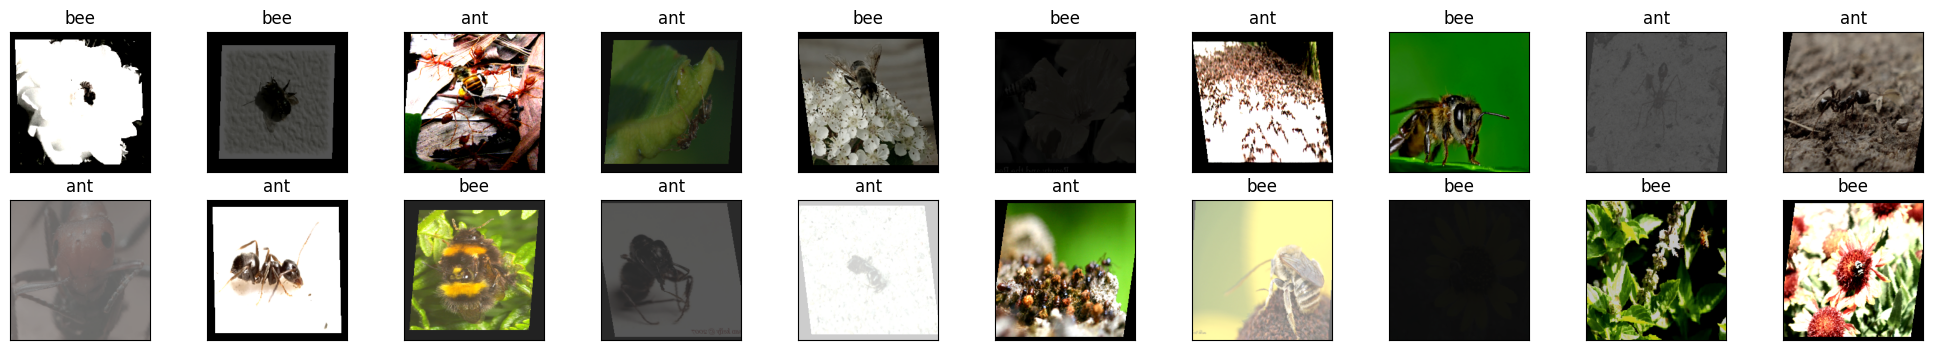

In [11]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [12]:
# For this example, we use the model pretrained and quantized with the ImageNet dataset
model = NeuroCorgiNet_torch([20, 3, 224, 224], weights_dir="data/imagenet_weights")

Adding cell (extractor) : bn1
Adding cell (extractor) : bn1_3x3_dw
Adding cell (extractor) : bn1_1x1
Adding cell (extractor) : bn2_3x3_dw
Adding cell (extractor) : bn2_1x1
Adding cell (extractor) : bn3_3x3_dw
Adding cell (extractor) : bn3_1x1
Adding cell (extractor) : bn4_3x3_dw
Adding cell (extractor) : bn4_1x1
Adding cell (extractor) : bn5_3x3_dw
Adding cell (extractor) : bn5_1x1
Adding cell (extractor) : bn6_3x3_dw
Adding cell (extractor) : bn6_1x1
Adding cell (extractor) : bn7_1_3x3_dw
Adding cell (extractor) : bn7_1_1x1
Adding cell (extractor) : bn7_2_3x3_dw
Adding cell (extractor) : bn7_2_1x1
Adding cell (extractor) : bn7_3_3x3_dw
Adding cell (extractor) : bn7_3_1x1
Adding cell (extractor) : bn7_4_3x3_dw
Adding cell (extractor) : bn7_4_1x1
Adding cell (extractor) : bn7_5_3x3_dw
Adding cell (extractor) : bn7_5_1x1
Adding cell (extractor) : bn8_3x3_dw
Adding cell (extractor) : bn8_1x1
Adding cell (extractor) : bn9_3x3_dw
Adding cell (extractor) : bn9_1x1
      Quantizer::SAT ||  Qu

In [25]:
print(model)

'DeepNet_0' NeuroCorgiNet(
	(0): 'conv1' Conv(Frame_CUDA<float>)(nb_inputs=3, nb_outputs=32, kernel_dims=[3, 3], sub_sample_dims=[1, 1], stride_dims=[2, 2], padding_dims=[1, 1], dilation_dims=[1, 1])
	(1): 'conv1_3x3_dw' Conv(Frame_CUDA<float>)(nb_inputs=32, nb_outputs=32, kernel_dims=[3, 3], sub_sample_dims=[1, 1], stride_dims=[1, 1], padding_dims=[1, 1], dilation_dims=[1, 1])(['conv1'])
	(2): 'conv1_1x1' Conv(Frame_CUDA<float>)(nb_inputs=32, nb_outputs=64, kernel_dims=[1, 1], sub_sample_dims=[1, 1], stride_dims=[1, 1], padding_dims=[0, 0], dilation_dims=[1, 1])(['conv1_3x3_dw'])
	(3): 'conv2_3x3_dw' Conv(Frame_CUDA<float>)(nb_inputs=64, nb_outputs=64, kernel_dims=[3, 3], sub_sample_dims=[1, 1], stride_dims=[2, 2], padding_dims=[1, 1], dilation_dims=[1, 1])(['conv1_1x1'])
	(4): 'conv2_1x1' Conv(Frame_CUDA<float>)(nb_inputs=64, nb_outputs=128, kernel_dims=[1, 1], sub_sample_dims=[1, 1], stride_dims=[1, 1], padding_dims=[0, 0], dilation_dims=[1, 1])(['conv2_3x3_dw'])
	(5): 'conv3_3x3_dw

In [14]:
pool = torch.nn.AvgPool2d(7, stride=7)
flatten = torch.nn.Flatten(start_dim=1)
classifier = torch.nn.Linear(1024, len(classes))
head = torch.nn.Sequential(pool, flatten, classifier)
head.to(device)

Sequential(
  (0): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=2, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(head.parameters(), lr = 0.01)

In [16]:
model = model.eval()
head = head.train()

In [17]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = model(inputs)
    outputs = head(conv9_1x1)

    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)

          conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = model(val_inputs)
          val_outputs = head(conv9_1x1)

          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)
        
      epoch_loss = running_loss/len(training_loader.dataset)
      epoch_acc = running_corrects.float()/ len(training_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      
      val_epoch_loss = val_running_loss/len(validation_loader.dataset)
      val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0618, acc 0.6230 
validation loss: 0.0249, validation acc 0.8431 
epoch : 2
training loss: 0.0320, acc 0.7705 
validation loss: 0.0309, validation acc 0.8301 
epoch : 3
training loss: 0.0240, acc 0.8361 
validation loss: 0.0413, validation acc 0.7582 
epoch : 4
training loss: 0.0186, acc 0.8689 
validation loss: 0.0274, validation acc 0.8366 
epoch : 5
training loss: 0.0160, acc 0.8770 
validation loss: 0.0255, validation acc 0.8366 


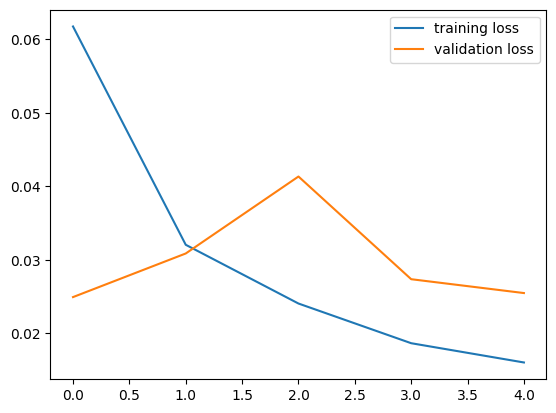

In [18]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

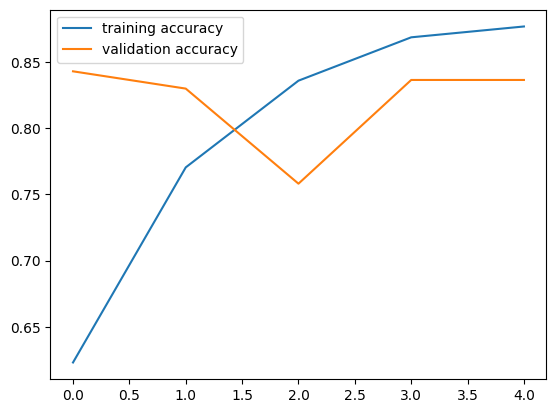

In [19]:
running_corrects_history = [x.to("cpu") for x in running_corrects_history]
val_running_corrects_history = [x.to("cpu") for x in val_running_corrects_history]

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

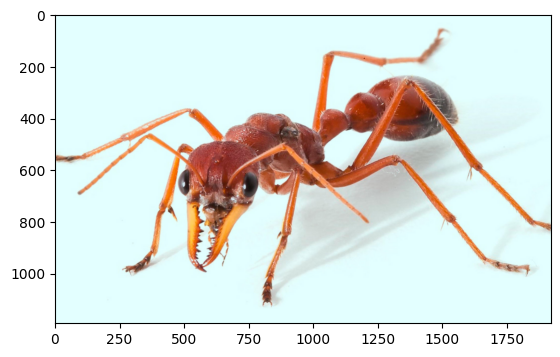

In [20]:
import requests
from PIL import Image

url = 'https://cdn.sci.news/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

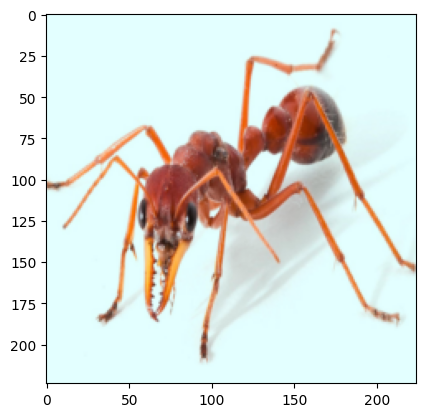

In [21]:
img = transform(img) 
plt.imshow(im_convert(img))

In [22]:
model_one_img = NeuroCorgiNet_torch([1, 3, 224, 224], weights_dir="data/imagenet_weights")

Adding cell (extractor) : bn1
Adding cell (extractor) : bn1_3x3_dw
Adding cell (extractor) : bn1_1x1
Adding cell (extractor) : bn2_3x3_dw
Adding cell (extractor) : bn2_1x1
Adding cell (extractor) : bn3_3x3_dw
Adding cell (extractor) : bn3_1x1
Adding cell (extractor) : bn4_3x3_dw
Adding cell (extractor) : bn4_1x1
Adding cell (extractor) : bn5_3x3_dw
Adding cell (extractor) : bn5_1x1
Adding cell (extractor) : bn6_3x3_dw
Adding cell (extractor) : bn6_1x1
Adding cell (extractor) : bn7_1_3x3_dw
Adding cell (extractor) : bn7_1_1x1
Adding cell (extractor) : bn7_2_3x3_dw
Adding cell (extractor) : bn7_2_1x1
Adding cell (extractor) : bn7_3_3x3_dw
Adding cell (extractor) : bn7_3_1x1
Adding cell (extractor) : bn7_4_3x3_dw
Adding cell (extractor) : bn7_4_1x1
Adding cell (extractor) : bn7_5_3x3_dw
Adding cell (extractor) : bn7_5_1x1
Adding cell (extractor) : bn8_3x3_dw
Adding cell (extractor) : bn8_1x1
Adding cell (extractor) : bn9_3x3_dw
Adding cell (extractor) : bn9_1x1
      Quantizer::SAT ||  Qu

In [23]:
image = img.to(device).unsqueeze(0)
conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = model_one_img(image)
output = head(conv9_1x1)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


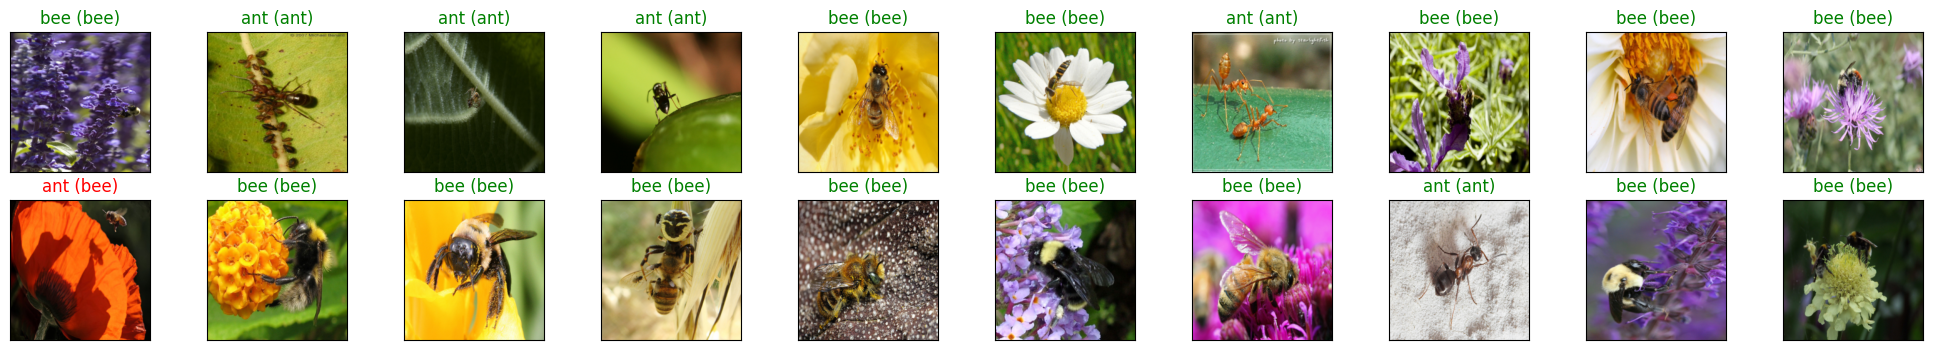

In [24]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = model(images)
output = head(conv9_1x1)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))